In [3]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
!pip install gym

In [5]:
!apt-get install python-opengl -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [6]:
!pip install pyvirtualdisplay
!pip install piglet

In [7]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [8]:
%matplotlib inline

In [9]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v1').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:

state = env.reset()
action = env.action_space.sample()

print('State space: ', env.observation_space)
print('Initial state: ', state)
print('\nAction space: ', env.action_space)
print('Random action: ', action)


State space:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Initial state:  [ 0.03075235 -0.01323796  0.00613824 -0.00498641]

Action space:  Discrete(2)
Random action:  1


In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
class DQN(nn.Module):

    def __init__(self, h, w):#이미지가 들어 갈 것이기에 CNN으로 학습
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


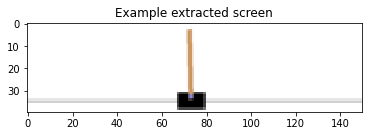

In [13]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold *2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 1.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 2)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [14]:
BATCH_SIZE = 256#agent로부터 쌓은 기억 중 몇 개를 뽑을 지 결정 => 초기엔 256개가 없기에 랜덤하게 생성함
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5#policy를 10번 학습 할 때 마다 target을 update하겠다는 말

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

policy_net = DQN(screen_height, screen_width).to(device)#학습은 policy_net이 하는 것
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())#학습한 policy를 target에 저장하는데 이를 불러오는 코드
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = 0.001)
memory = ReplayMemory(10000)#replay buffer의 size = 10000

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1): 각 행의 열에 대해 가장 큰 값을 반환
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations():#시각화를 위한 function
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)#memory로부터 Batch_size만큼 불러옴
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber Loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

1번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


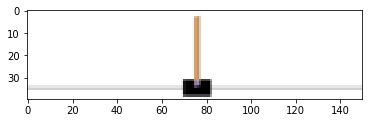

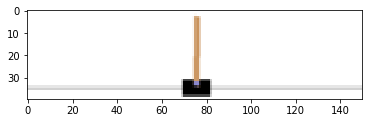

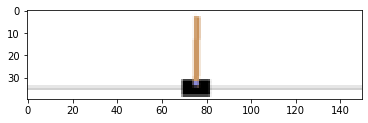

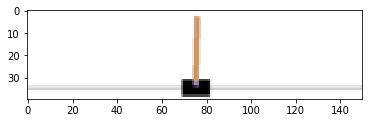

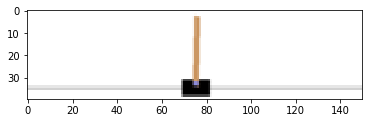

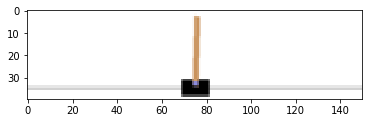

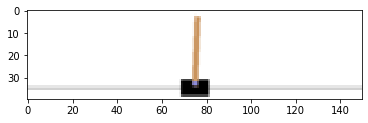

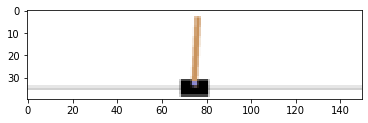

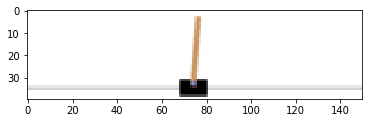

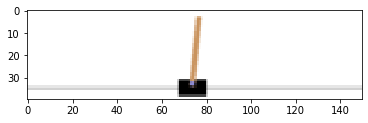

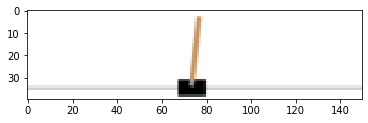

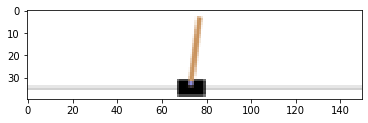

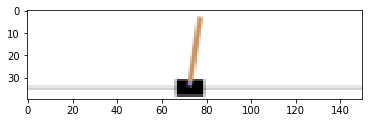

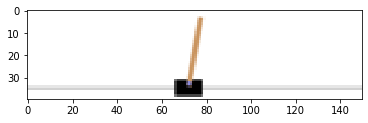

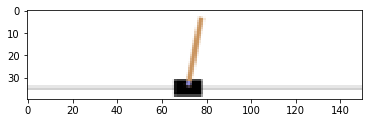

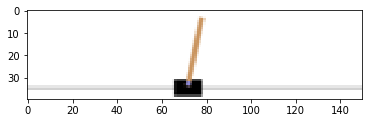

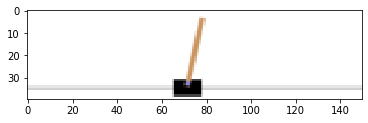

1번째 에피소드 학습 결과: 17번 생존
2번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


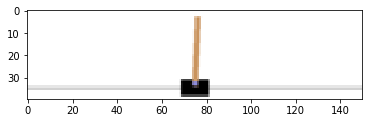

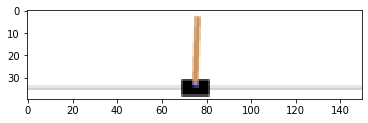

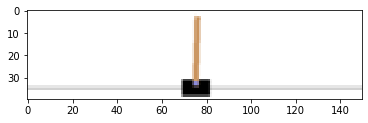

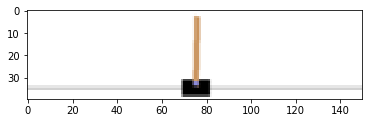

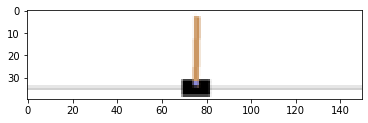

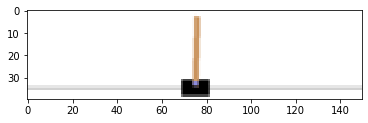

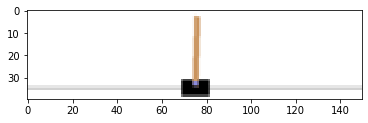

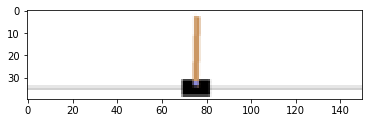

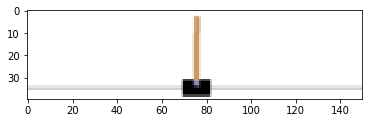

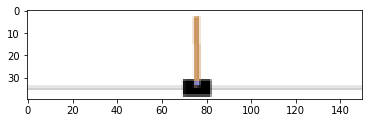

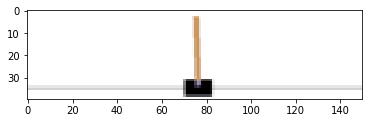

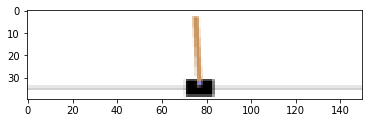

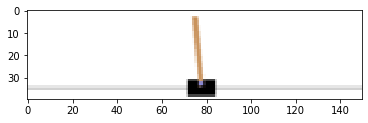

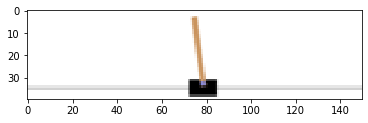

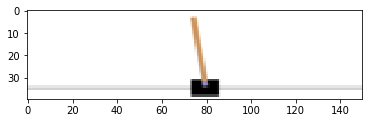

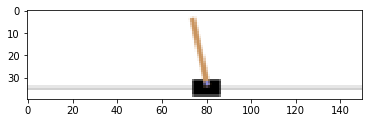

2번째 에피소드 학습 결과: 16번 생존
3번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


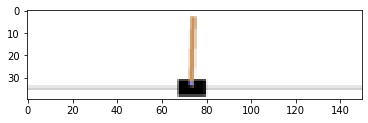

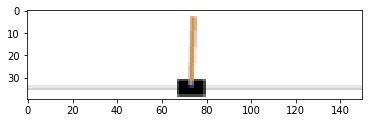

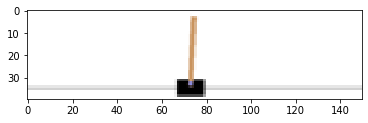

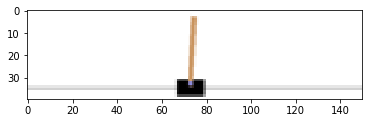

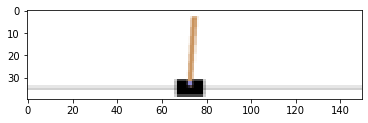

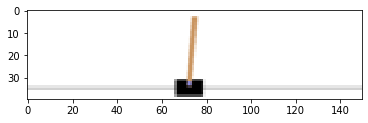

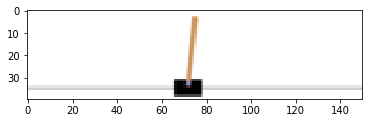

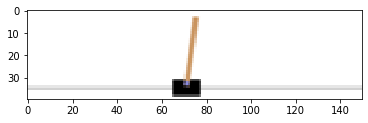

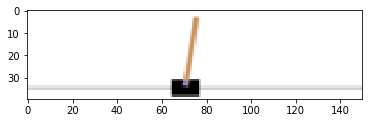

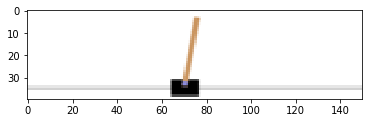

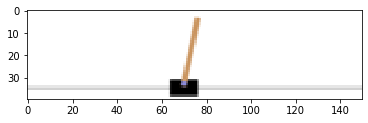

3번째 에피소드 학습 결과: 11번 생존
4번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


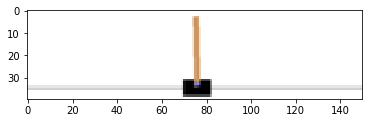

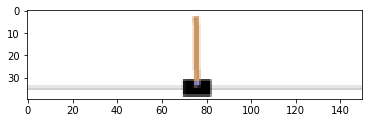

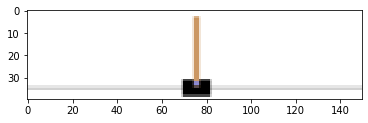

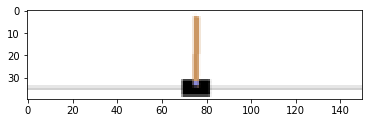

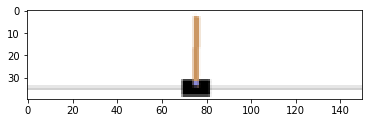

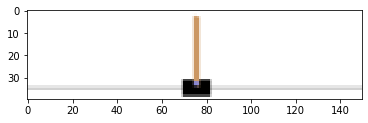

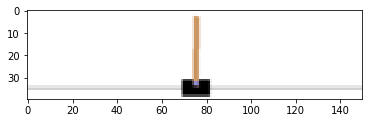

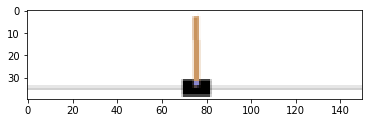

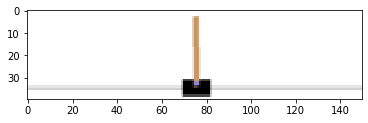

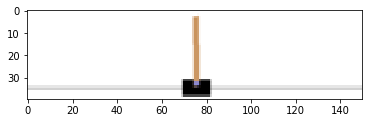

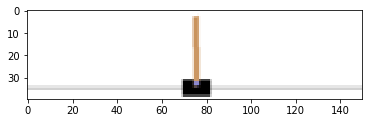

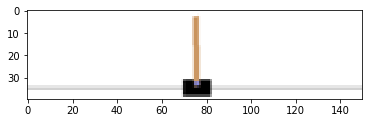

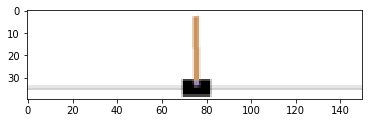

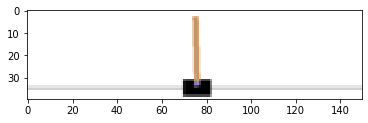

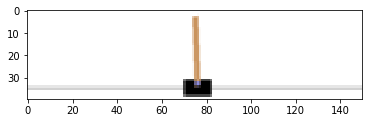

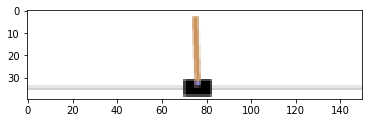

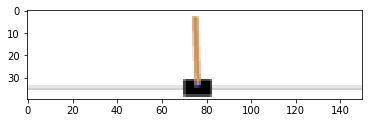

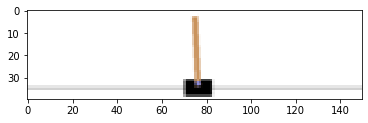

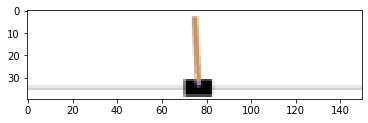

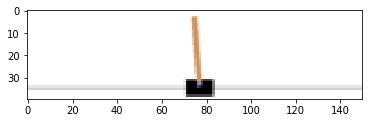

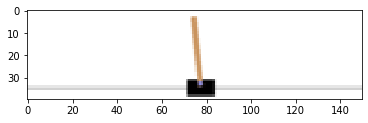

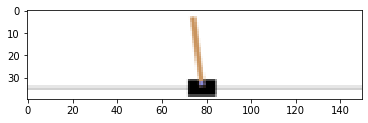

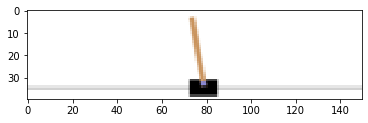

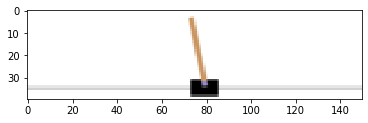

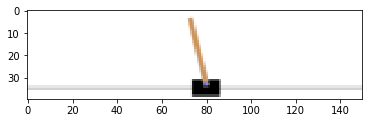

4번째 에피소드 학습 결과: 25번 생존
5번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


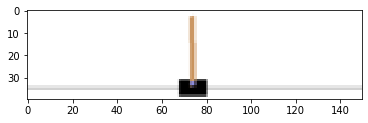

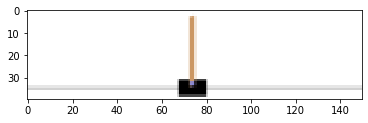

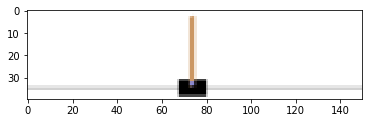

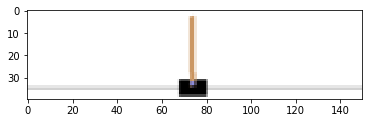

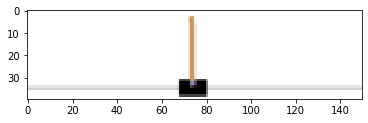

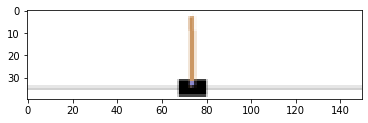

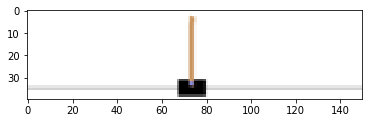

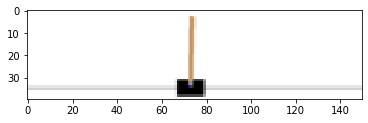

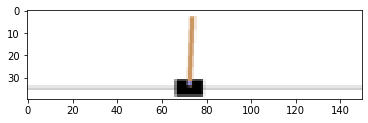

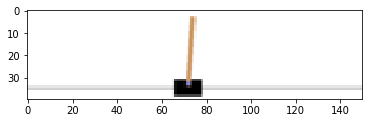

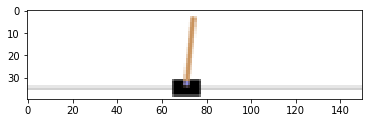

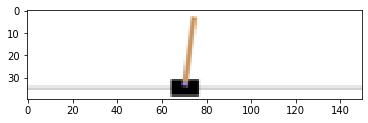

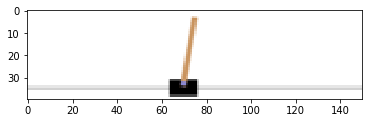

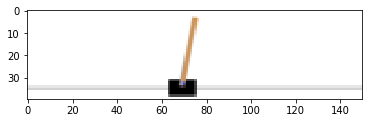

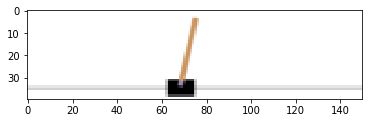

5번째 에피소드 학습 결과: 15번 생존
6번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


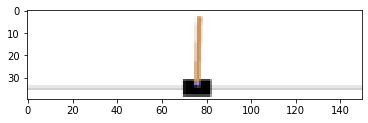

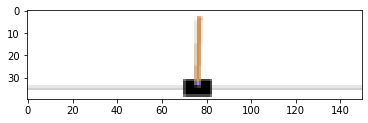

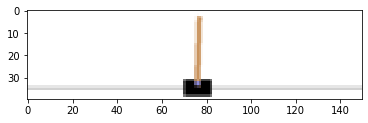

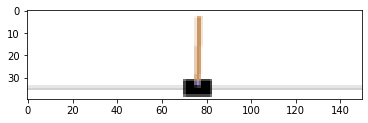

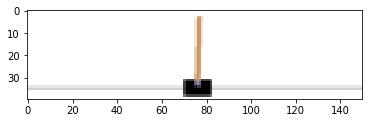

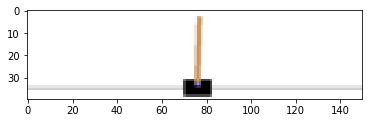

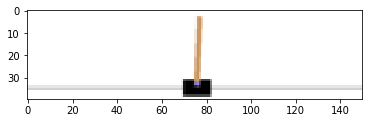

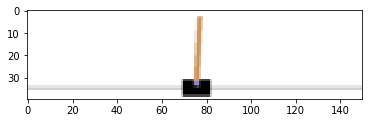

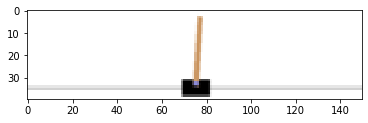

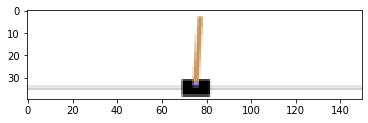

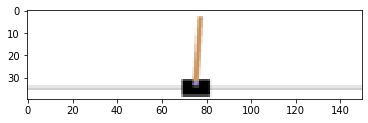

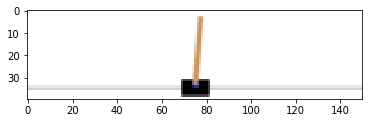

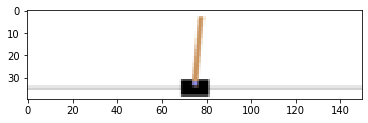

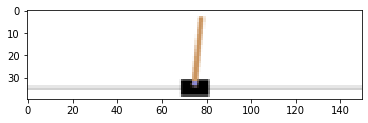

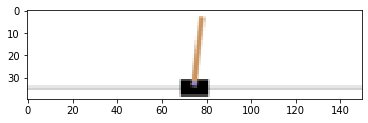

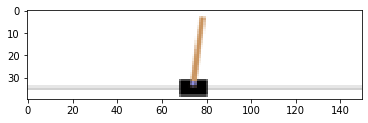

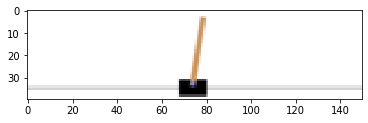

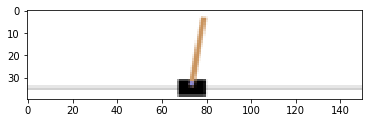

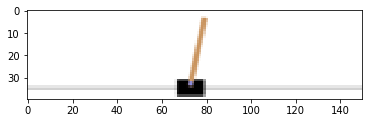

6번째 에피소드 학습 결과: 19번 생존
7번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


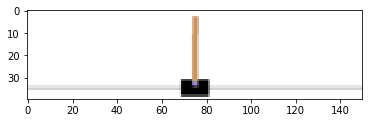

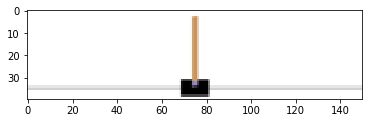

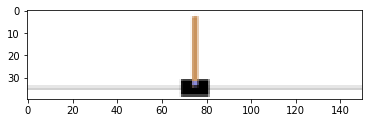

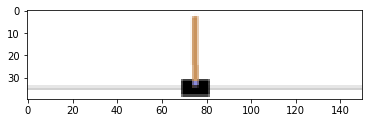

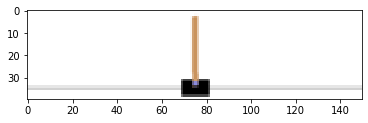

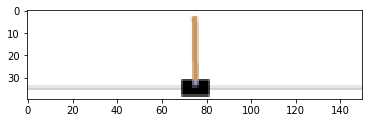

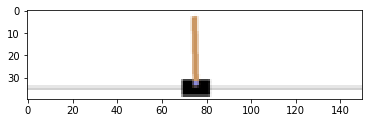

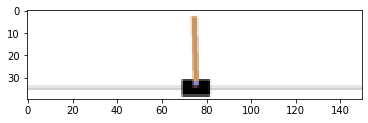

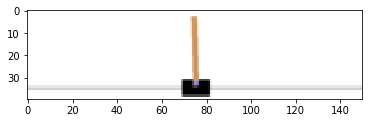

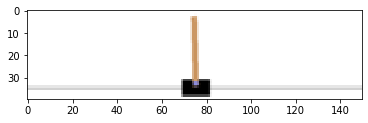

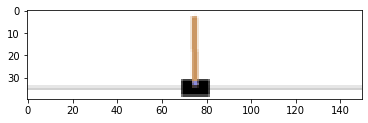

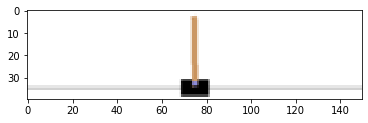

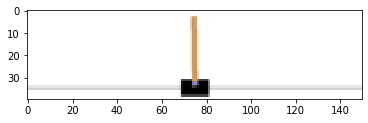

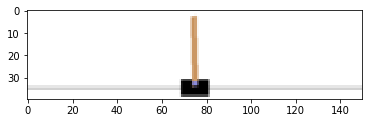

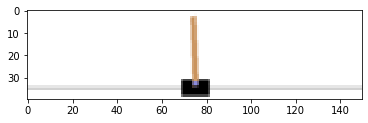

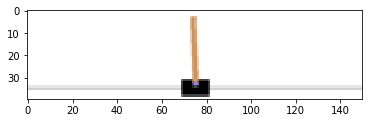

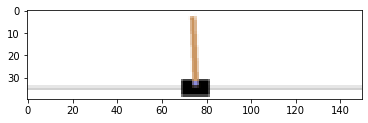

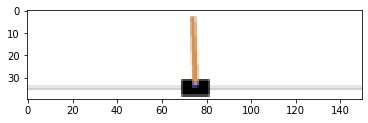

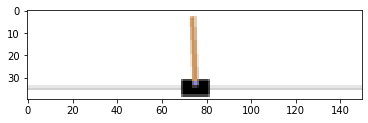

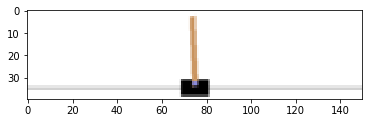

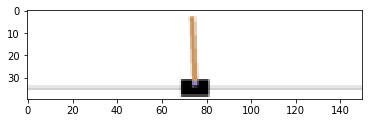

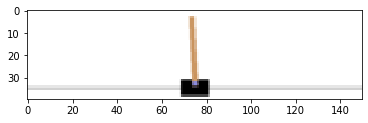

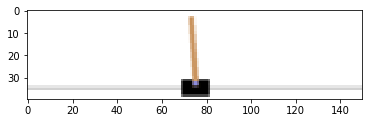

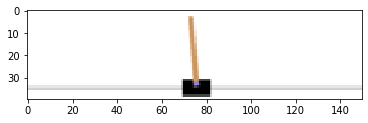

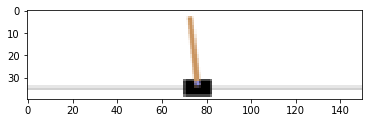

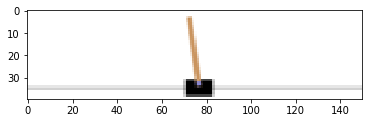

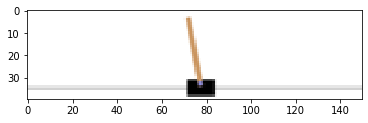

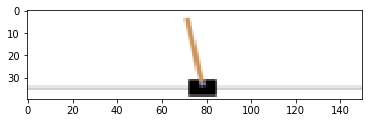

7번째 에피소드 학습 결과: 28번 생존
8번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


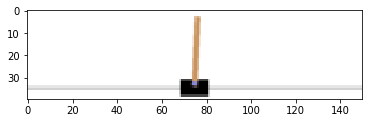

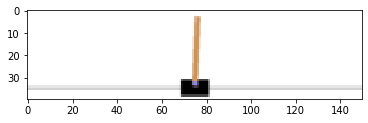

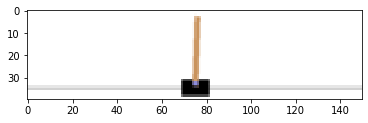

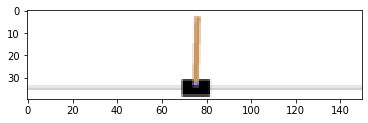

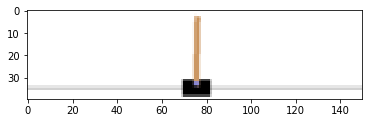

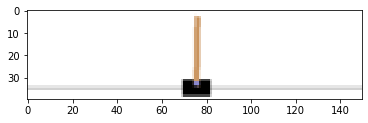

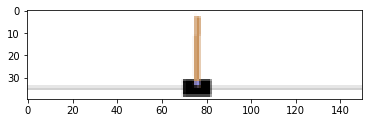

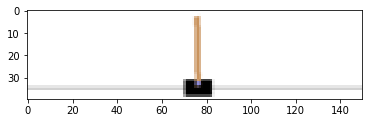

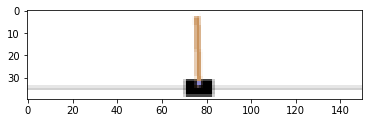

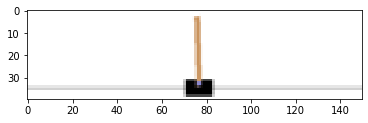

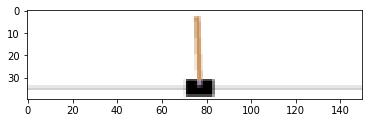

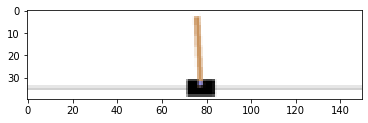

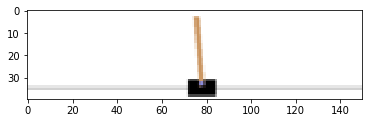

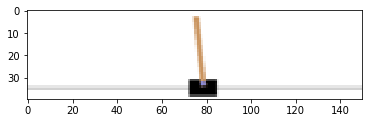

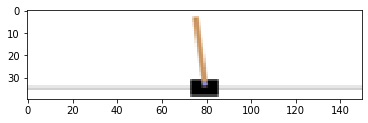

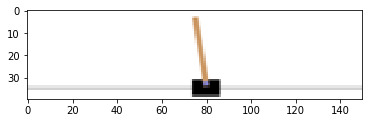

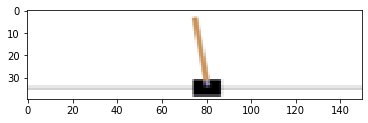

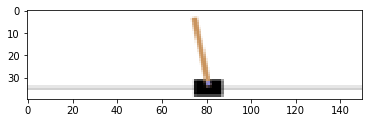

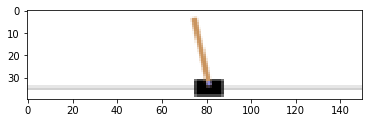

8번째 에피소드 학습 결과: 19번 생존
9번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


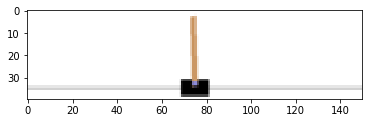

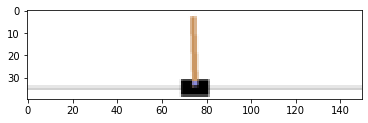

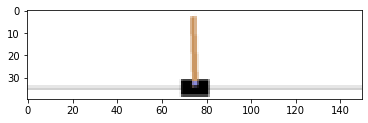

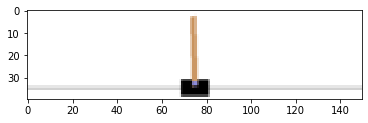

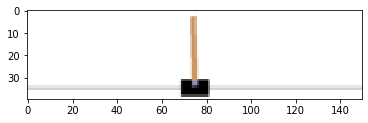

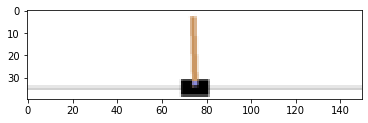

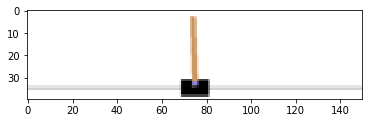

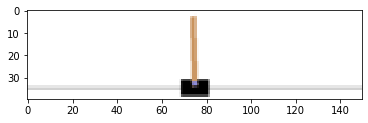

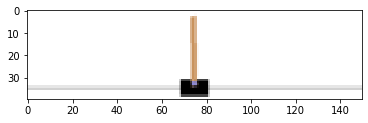

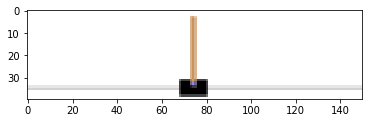

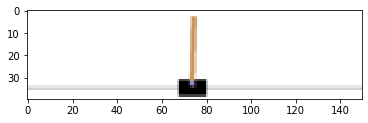

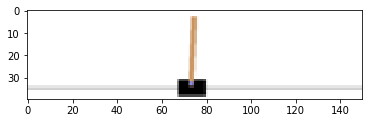

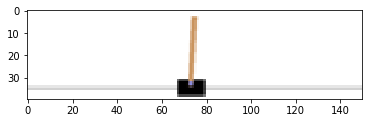

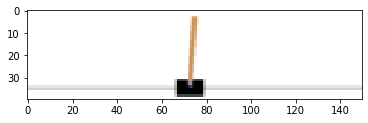

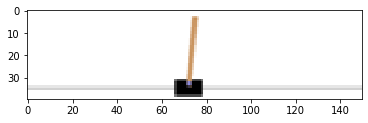

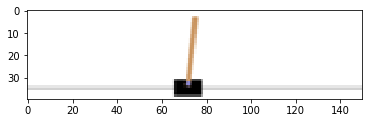

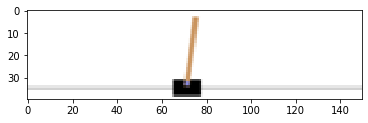

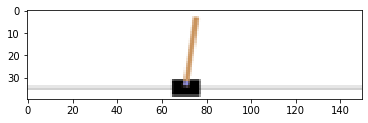

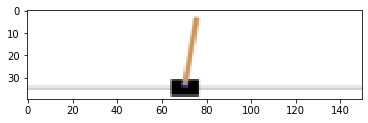

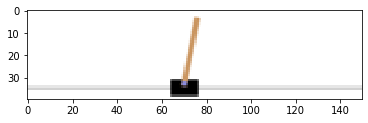

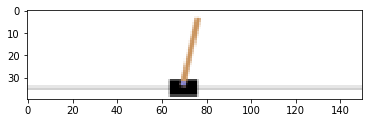

9번째 에피소드 학습 결과: 21번 생존
10번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


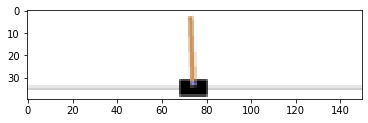

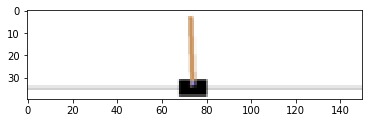

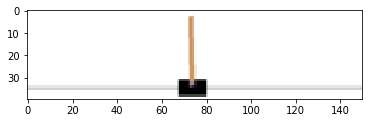

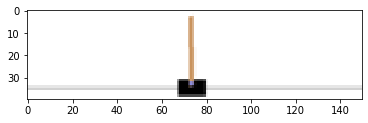

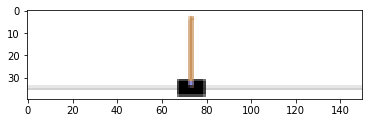

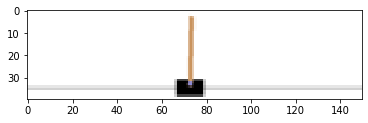

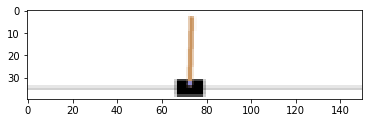

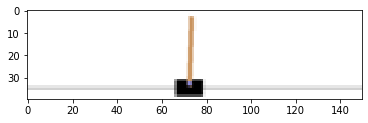

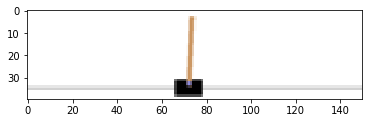

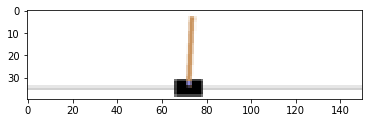

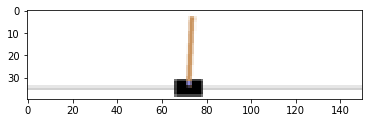

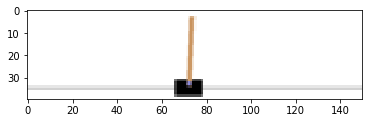

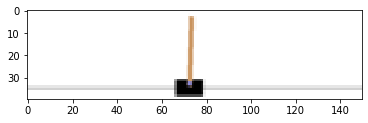

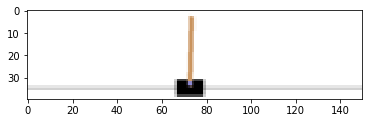

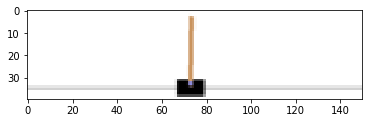

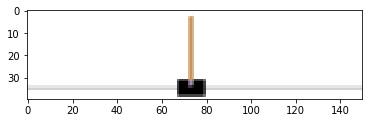

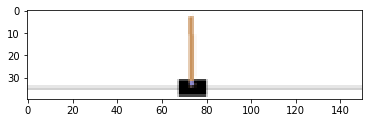

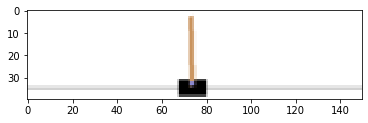

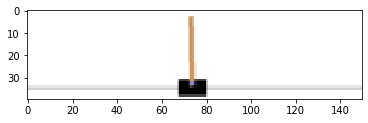

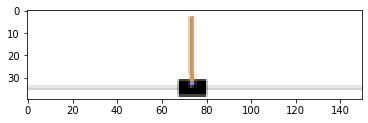

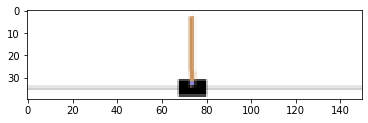

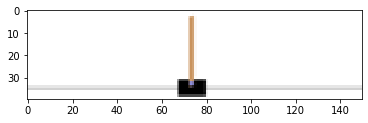

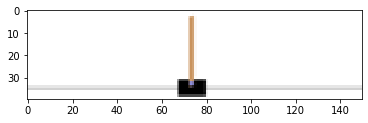

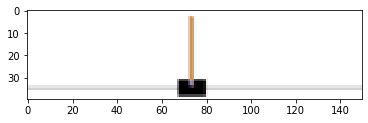

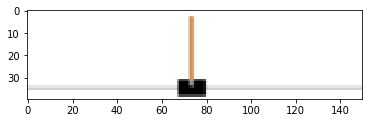

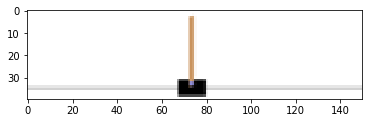

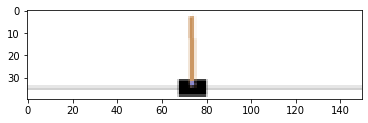

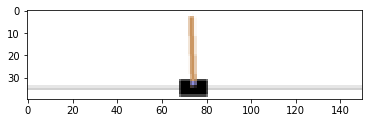

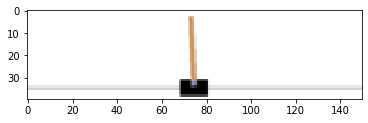

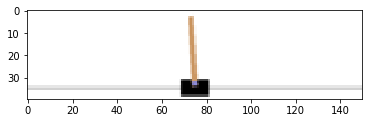

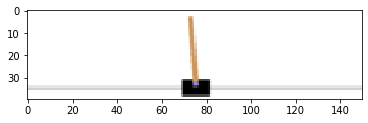

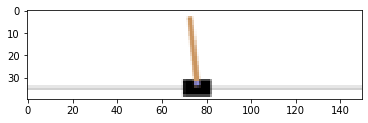

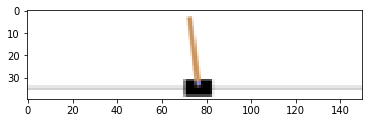

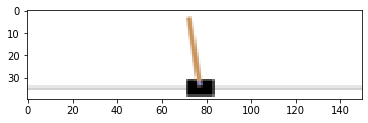

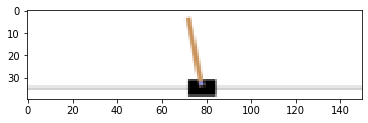

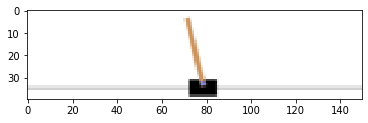

10번째 에피소드 학습 결과: 36번 생존
11번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


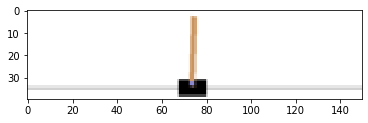

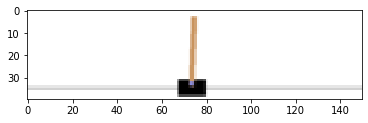

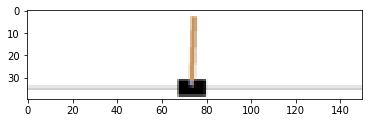

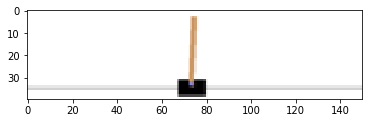

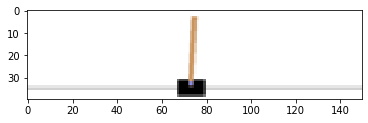

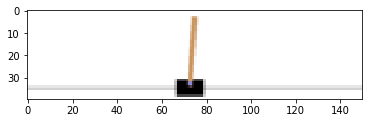

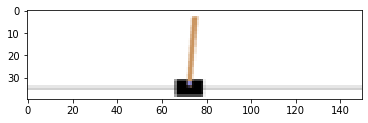

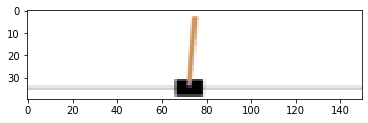

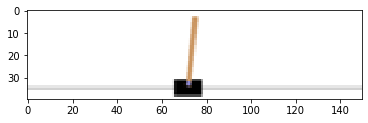

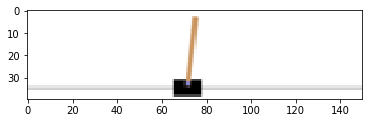

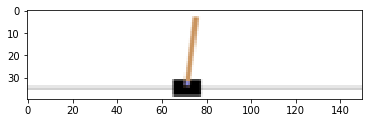

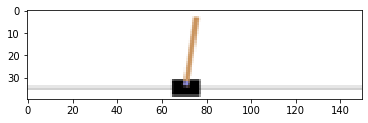

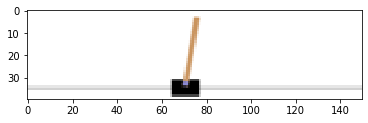

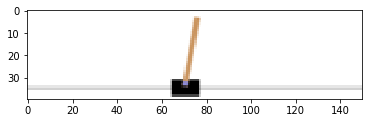

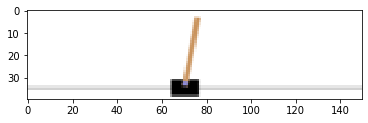

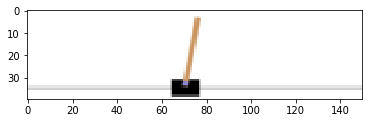

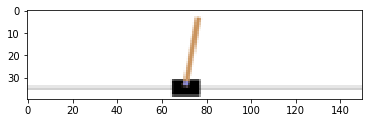

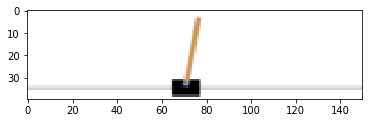

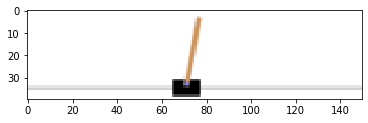

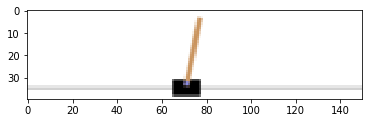

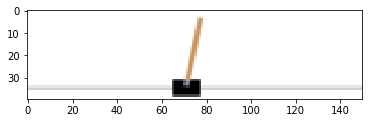

11번째 에피소드 학습 결과: 21번 생존
12번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


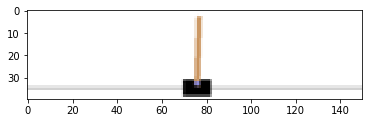

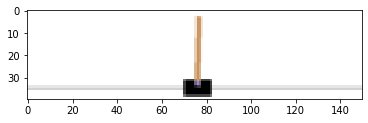

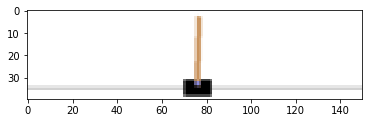

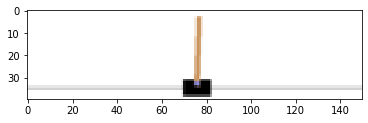

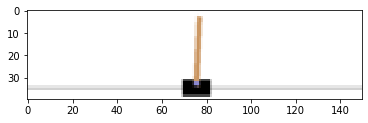

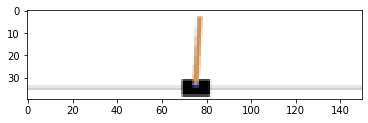

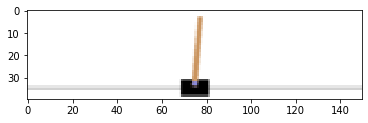

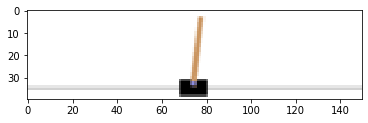

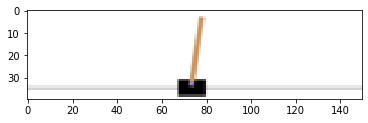

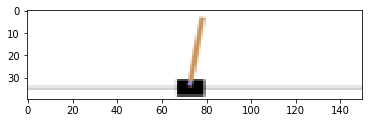

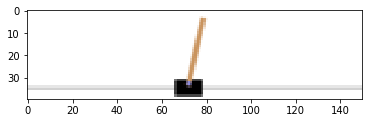

12번째 에피소드 학습 결과: 11번 생존
13번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


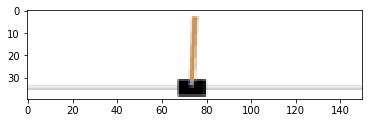

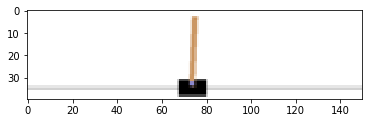

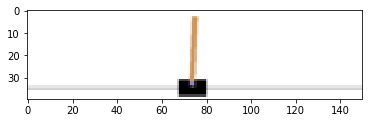

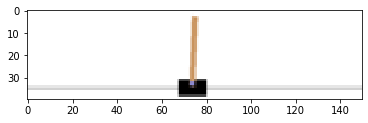

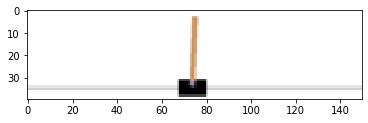

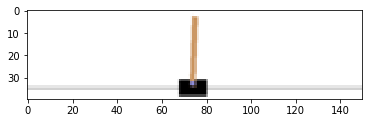

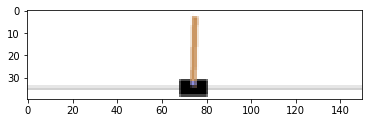

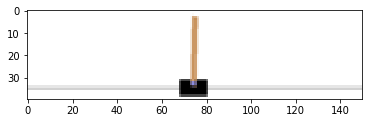

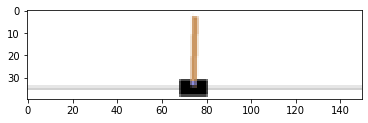

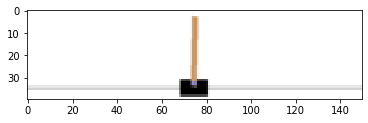

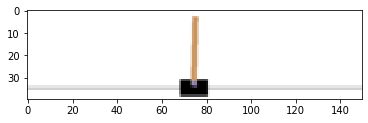

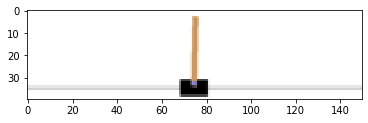

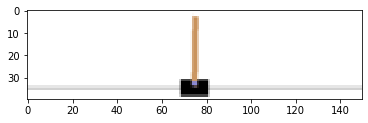

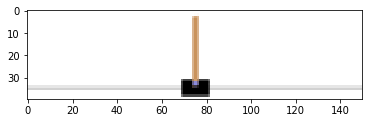

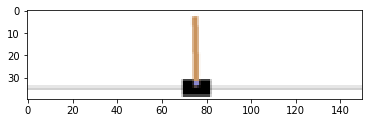

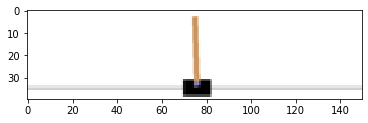

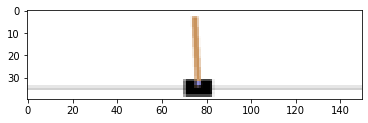

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


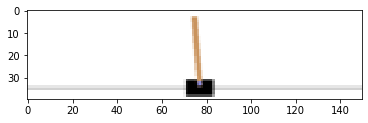

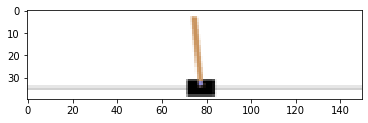

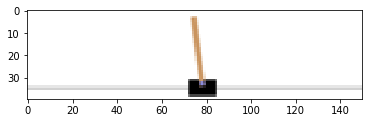

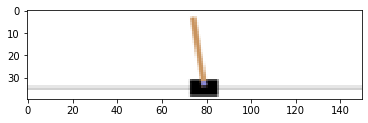

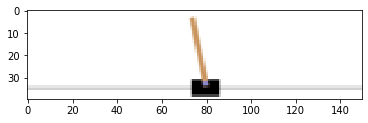

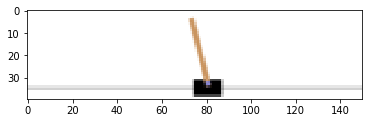

13번째 에피소드 학습 결과: 23번 생존
14번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


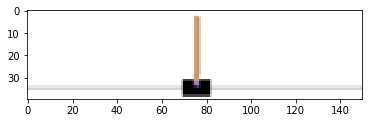

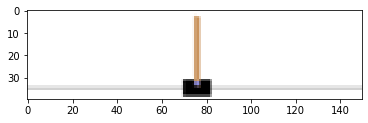

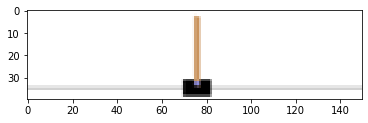

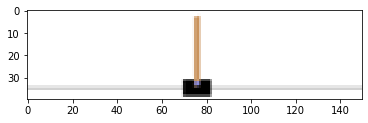

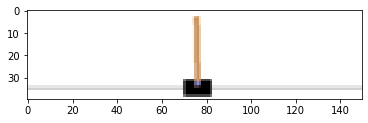

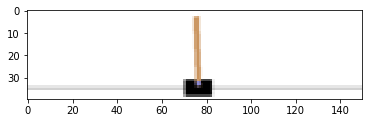

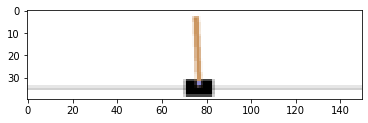

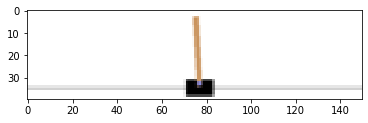

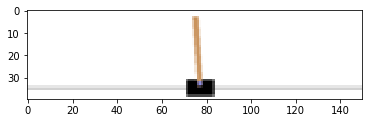

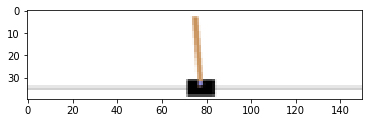

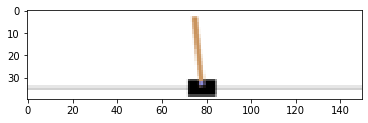

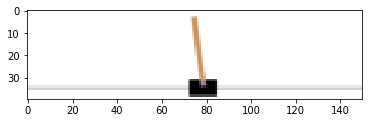

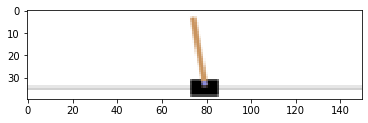

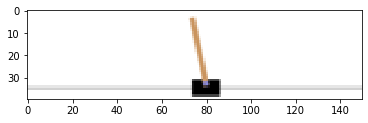

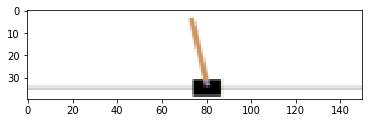

14번째 에피소드 학습 결과: 15번 생존
15번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


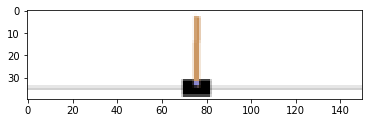

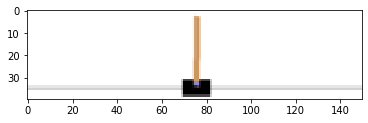

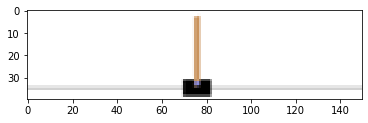

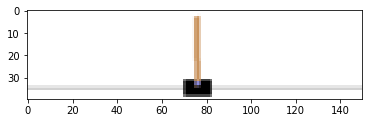

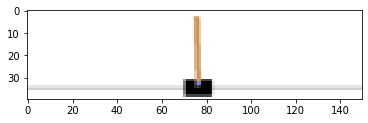

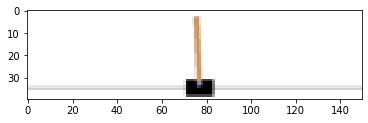

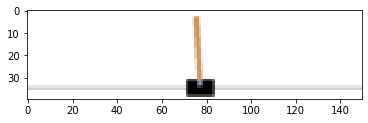

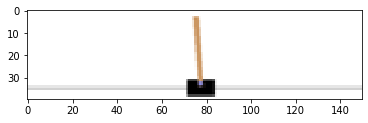

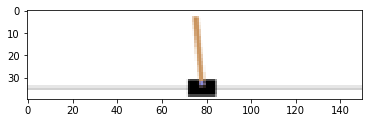

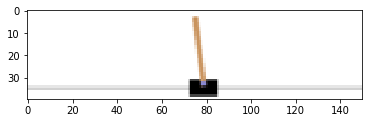

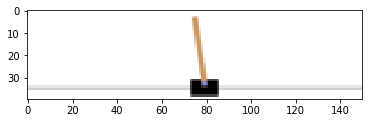

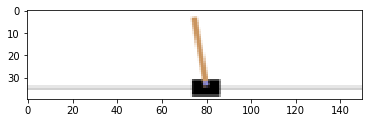

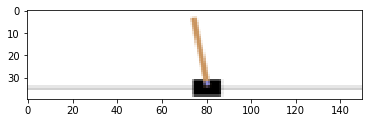

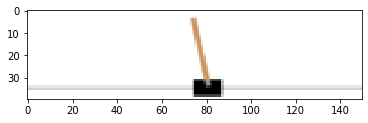

15번째 에피소드 학습 결과: 14번 생존
16번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


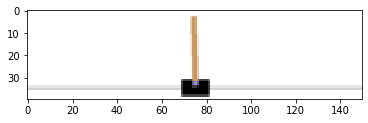

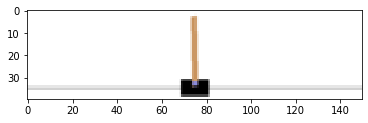

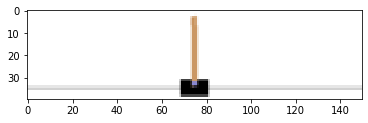

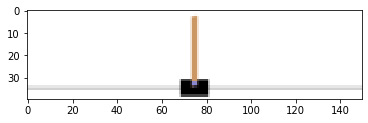

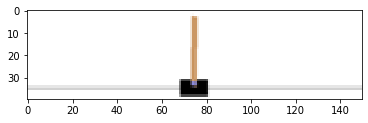

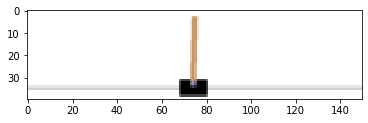

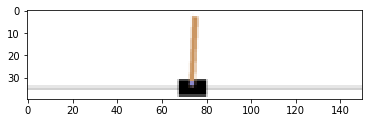

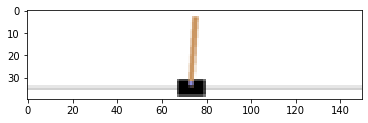

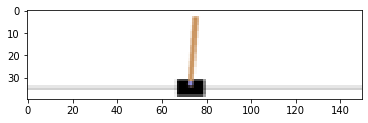

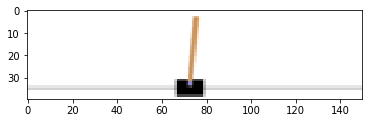

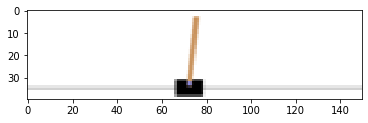

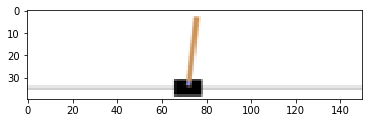

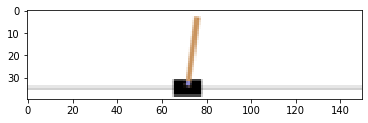

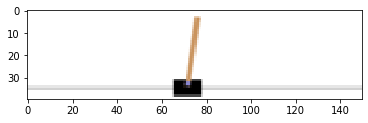

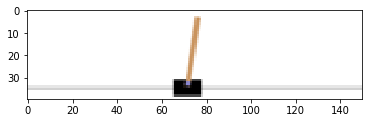

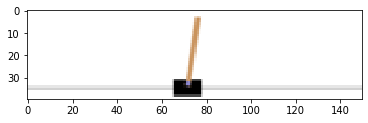

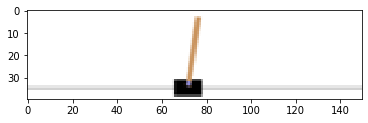

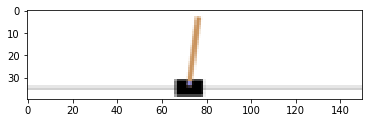

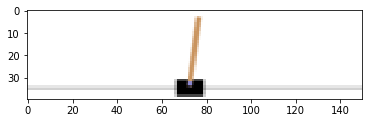

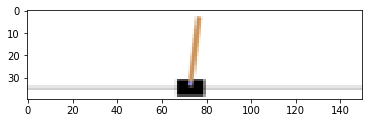

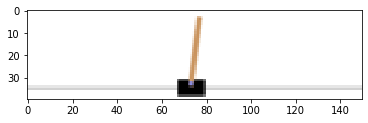

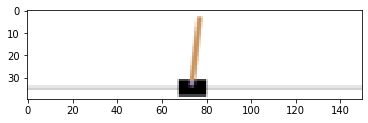

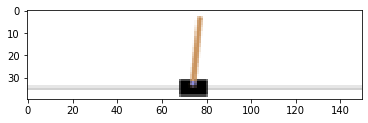

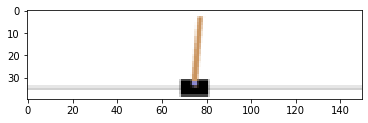

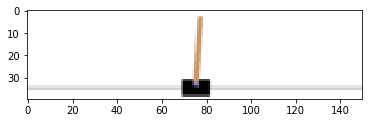

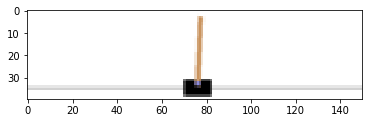

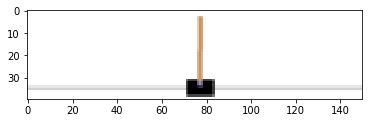

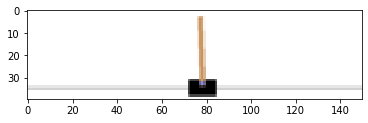

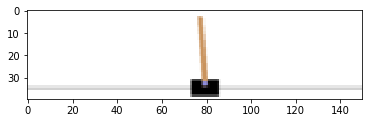

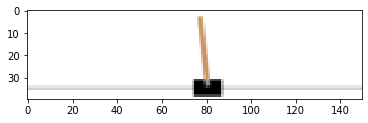

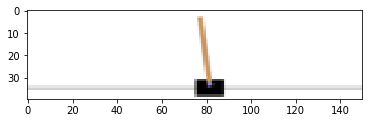

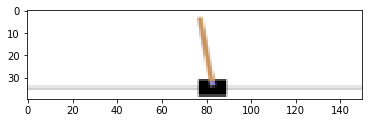

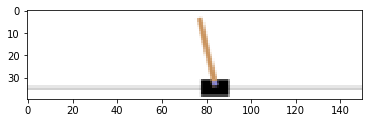

16번째 에피소드 학습 결과: 33번 생존
17번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


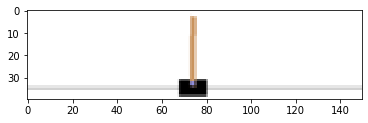

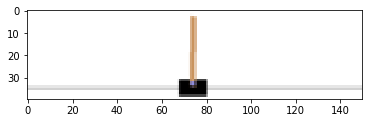

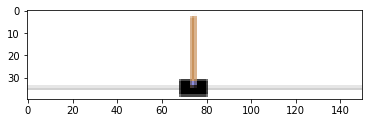

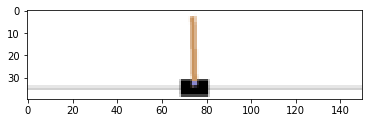

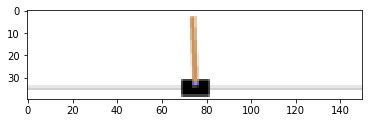

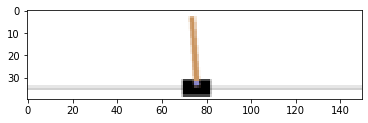

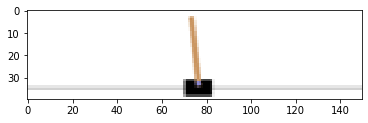

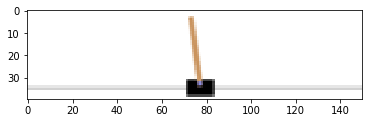

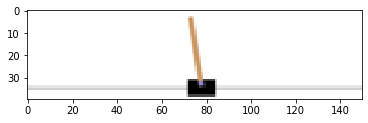

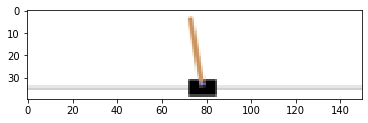

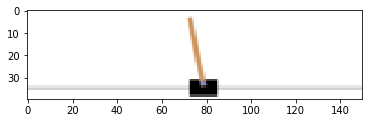

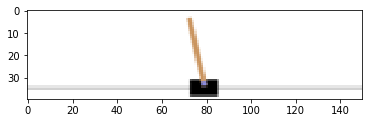

17번째 에피소드 학습 결과: 12번 생존
18번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


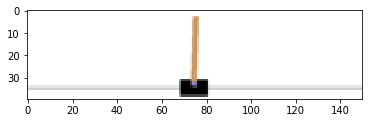

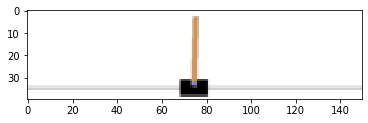

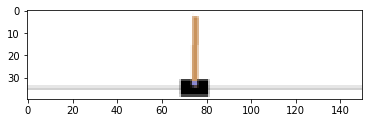

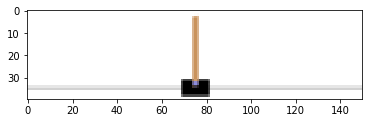

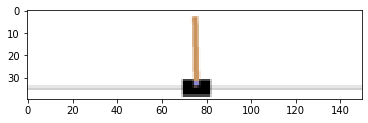

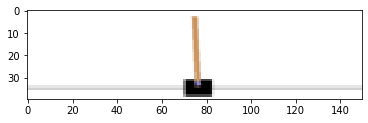

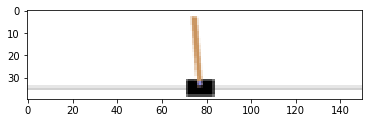

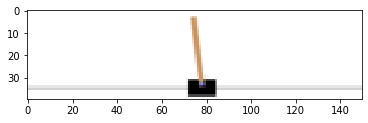

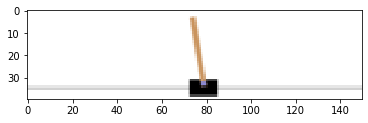

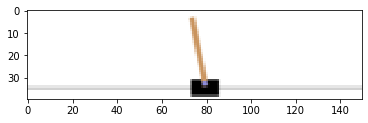

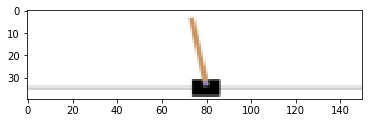

18번째 에피소드 학습 결과: 11번 생존
19번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


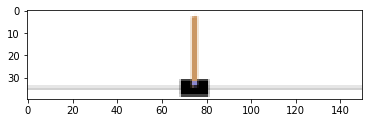

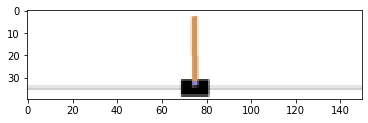

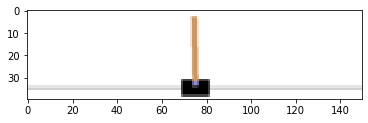

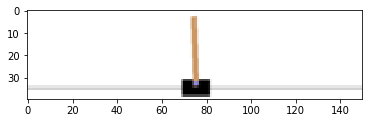

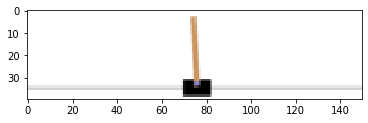

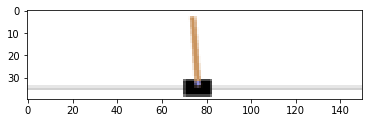

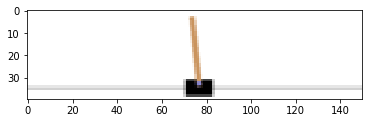

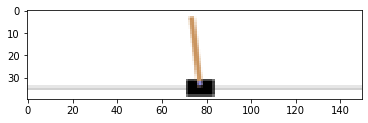

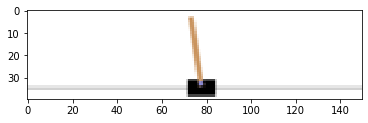

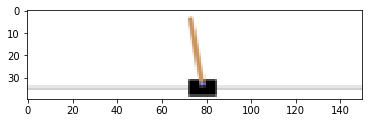

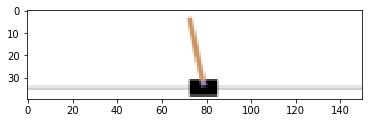

19번째 에피소드 학습 결과: 11번 생존
20번째 에피소드 학습 시작
1초 전 
2초 전 
3초 전 


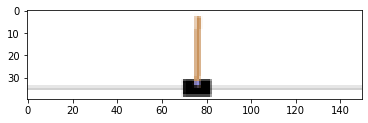

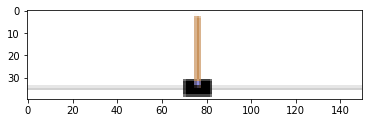

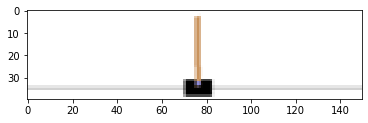

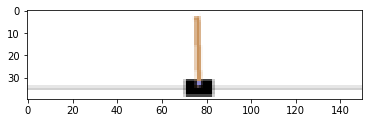

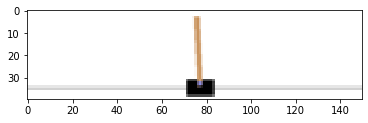

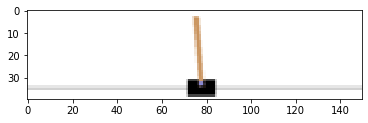

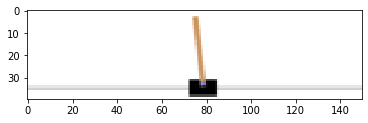

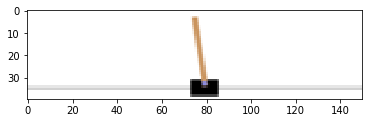

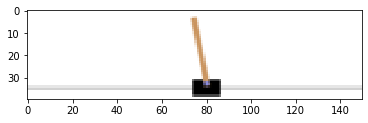

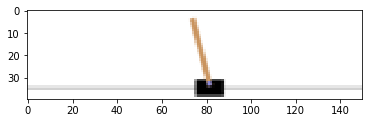

20번째 에피소드 학습 결과: 10번 생존


In [16]:
torch.manual_seed(10)
num_episodes = 20
max_step = []
for i_episode in range(num_episodes):
    print('{}번째 에피소드 학습 시작'.format(i_episode+1))
    for i in range(3):
      time.sleep(1)
      print('{}초 전 '.format(i+1))
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for idx, t in enumerate(count()):

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        plt.figure()
        plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
                  interpolation='none')
        plt.show()

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimizating network
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
        
    print('{}번째 에피소드 학습 결과: {}번 생존'.format(i_episode+1,idx+1))
    max_step.append(idx+1)

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


In [17]:
torch.manual_seed(10)
num_episodes = 2000
max_step = []
for i_episode in range(num_episodes):
    #print('{}번째 에피소드 학습 시작'.format(i_episode+1))
    '''
    for i in range(5):
      time.sleep(1)
      print('{}초 전 '.format(i+1))
    '''
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for idx, t in enumerate(count()):

        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        '''
        plt.figure()
        plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
                  interpolation='none')
        plt.show()
        '''
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimizating network
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
        
    print('{}번째 에피소드 학습 결과: {}번 생존'.format(i_episode+1,idx+1))
    #time.sleep(5)
    max_step.append(idx+1)

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


1번째 에피소드 학습 결과: 28번 생존
2번째 에피소드 학습 결과: 25번 생존
3번째 에피소드 학습 결과: 12번 생존
4번째 에피소드 학습 결과: 11번 생존
5번째 에피소드 학습 결과: 20번 생존
6번째 에피소드 학습 결과: 14번 생존
7번째 에피소드 학습 결과: 15번 생존
8번째 에피소드 학습 결과: 9번 생존
9번째 에피소드 학습 결과: 11번 생존
10번째 에피소드 학습 결과: 20번 생존
11번째 에피소드 학습 결과: 15번 생존
12번째 에피소드 학습 결과: 14번 생존
13번째 에피소드 학습 결과: 48번 생존
14번째 에피소드 학습 결과: 17번 생존
15번째 에피소드 학습 결과: 13번 생존
16번째 에피소드 학습 결과: 14번 생존
17번째 에피소드 학습 결과: 11번 생존
18번째 에피소드 학습 결과: 90번 생존
19번째 에피소드 학습 결과: 12번 생존
20번째 에피소드 학습 결과: 13번 생존
21번째 에피소드 학습 결과: 10번 생존
22번째 에피소드 학습 결과: 13번 생존
23번째 에피소드 학습 결과: 13번 생존
24번째 에피소드 학습 결과: 18번 생존
25번째 에피소드 학습 결과: 28번 생존
26번째 에피소드 학습 결과: 17번 생존
27번째 에피소드 학습 결과: 10번 생존
28번째 에피소드 학습 결과: 10번 생존
29번째 에피소드 학습 결과: 76번 생존
30번째 에피소드 학습 결과: 96번 생존
31번째 에피소드 학습 결과: 23번 생존
32번째 에피소드 학습 결과: 11번 생존
33번째 에피소드 학습 결과: 23번 생존
34번째 에피소드 학습 결과: 10번 생존
35번째 에피소드 학습 결과: 15번 생존
36번째 에피소드 학습 결과: 20번 생존
37번째 에피소드 학습 결과: 13번 생존
38번째 에피소드 학습 결과: 14번 생존
39번째 에피소드 학습 결과: 19번 생존
40번째 에피소드 학습 결과: 18번 생존
41번째 에피소드 학습 결과: 10번 생존
42번째 에피소드 학습 결과: 11번 생존
43

In [18]:
!pip install gym pyvirtualdisplay

In [19]:
!apt-get install xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [20]:
from gym.wrappers import Monitor

import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video(file_infix):
    with open('./video/openaigym.video.%s.video000000.mp4' % file_infix, 'r+b') as f:
        video = f.read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="Trained CartPole" autoplay 
                loop style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [21]:
num_state = env.observation_space.shape[0]
env = wrap_env(gym.make('CartPole-v1'))
state = env.reset()
done = False

mem = []

while not done:    
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    q_value = policy_net(state)
    mem.append(q_value[0].detach().cpu().numpy())
    action = np.argmax(q_value[0].detach().cpu().numpy())
    state, reward, done, info = env.step(action)

file_infix = env.file_infix
env.close()

show_video(file_infix)